##Membuat Model NLP dengan Tensorflow
Insyiraah Oxaichiko Arissinta

Kriteria Submission:
1. Dataset yang akan dipakai bebas, namun minimal memiliki 1000 sampel.

2. Harus menggunakan LSTM dalam arsitektur model.

3. Harus menggunakan model sequential.

4. Validation set sebesar 20% dari total dataset.

5. Harus menggunakan Embedding.

6. Harus menggunakan fungsi tokenizer.

7. Akurasi dari model minimal 75%.

Saran Submission
1. Akurasi dari model di atas 80%.

2. Mengimplementasikan callback.

3. Membuat plot loss dan akurasi pada saat training dan validation.

Klasifikasi teks multikelas menggunakan LSTM, pada submission ini saya akan menggunakan dataset Emotion.csv yang terdiri dari 6 kelas dan 21458 baris. Data tersebut saya peroleh dari rekan saya di kelas id camp (Arist).

In [10]:
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

##Import Library


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [13]:
print(tf.__version__)

2.6.0


In [14]:
df= pd.read_csv('Emotion.csv')

In [15]:
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [16]:
df.tail()

,Text,Emotion
21454,Melissa stared at her friend in dism,fear
21455,Successive state elections have seen the gover...,fear
21456,Vincent was irritated but not dismay,fear
21457,Kendall-Hume turned back to face the dismayed ...,fear
21458,"I am dismayed , but not surpris",fear


In [17]:
df.shape

(21459, 2)

In [18]:
df.Emotion.value_counts()

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64

Karena label kita berupa data kategorial, maka perlu melakukan one-hot-encoding

In [20]:
emotion = pd.get_dummies(df.Emotion)
data_new = pd.concat([df, emotion], axis=1)
data_new = data_new.drop(columns='Emotion')
data_new.head()

,Text,anger,fear,happy,love,sadness,surprise
0,i didnt feel humiliated,0,0,0,0,1,0
1,i can go from feeling so hopeless to so damned...,0,0,0,0,1,0
2,im grabbing a minute to post i feel greedy wrong,1,0,0,0,0,0
3,i am ever feeling nostalgic about the fireplac...,0,0,0,1,0,0
4,i am feeling grouchy,1,0,0,0,0,0


Agar dapat diproses oleh model, maka kita perlu mengubah nilai-nilai dari dataframe ke dalam tipe data numpy array menggunakan atribut values

In [21]:
text = data_new['Text'].values
emot = data_new[['anger',	'fear',	'happy',	'love',	'sadness',	'surprise']].values


In [22]:
text

array(['i didnt feel humiliated',
       'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
       'im grabbing a minute to post i feel greedy wrong', ...,
       'Vincent was irritated but not dismay',
       'Kendall-Hume turned back to face the dismayed coup',
       'I am dismayed , but not surpris'], dtype=object)

In [23]:
emot

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]], dtype=uint8)

##Split Dataset Menjadi Data Training dan Data Testing

In [24]:
text_train, text_test, emot_train, emot_test = train_test_split(text, emot, test_size=0.2, random_state=42)

##Tokenizer

Kemudian kita ubah setiap kata pada dataset kita ke dalam bilangan numerik dengan fungsi Tokenizer. Setelah tokenisasi selesai, kita perlu membuat mengonversi setiap sampel menjadi sequence.

In [25]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(text_train) 
tokenizer.fit_on_texts(text_test)
 
seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_test)
 
pad_train = pad_sequences(seq_train)
pad_test = pad_sequences(seq_test)

##Callback

Agar running berhenti ketika sampai pada akurasi yang maksimum

In [26]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_lr=1.5e-5
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=12,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

##Plot Modelling History

In [27]:
plt.style.use('seaborn-whitegrid')

def plot_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.subplot(1, 2, 1)
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])


def plot_loss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.subplot(1, 2, 2)
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

def plot_history(history):
  plt.figure(figsize=(15,5))
  plot_acc(history)
  plot_loss(history)

##Model Sequential Menggunakan CNN

In [28]:
tf.keras.backend.clear_session()

model_emot = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=20000, output_dim=64),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(6, activation='softmax')
])

model_emot.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          1280000   
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 1,313,414
Trainable params: 1,313,414
Non-trainable params: 0
_________________________________________________________________


In [29]:
model_emot.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

history_emot = model_emot.fit(
    pad_train, 
    emot_train,
    epochs=100,
    callbacks = [reduce_lr, early_stop],
    verbose=1,
    validation_data=(pad_test, emot_test)
)

Epoch 1/100
537/537 [==============================] - 36s 63ms/step - loss: 0.4034 - accuracy: 0.3918 - val_loss: 0.2854 - val_accuracy: 0.6149
Epoch 2/100
537/537 [==============================] - 34s 63ms/step - loss: 0.2156 - accuracy: 0.7408 - val_loss: 0.1432 - val_accuracy: 0.8381
Epoch 3/100
537/537 [==============================] - 33s 61ms/step - loss: 0.1144 - accuracy: 0.8814 - val_loss: 0.0986 - val_accuracy: 0.8924
Epoch 4/100
537/537 [==============================] - 33s 62ms/step - loss: 0.0803 - accuracy: 0.9212 - val_loss: 0.0795 - val_accuracy: 0.9091
Epoch 5/100
537/537 [==============================] - 33s 61ms/step - loss: 0.0604 - accuracy: 0.9435 - val_loss: 0.0775 - val_accuracy: 0.9161
Epoch 6/100
537/537 [==============================] - 33s 61ms/step - loss: 0.0487 - accuracy: 0.9553 - val_loss: 0.0920 - val_accuracy: 0.8986
Epoch 7/100
537/537 [==============================] - 33s 61ms/step - loss: 0.0411 - accuracy: 0.9622 - val_loss: 0.0731 - val_ac

Selanjutnya membuat plot Loss dan Plot Akurasi pada saat training dan validation

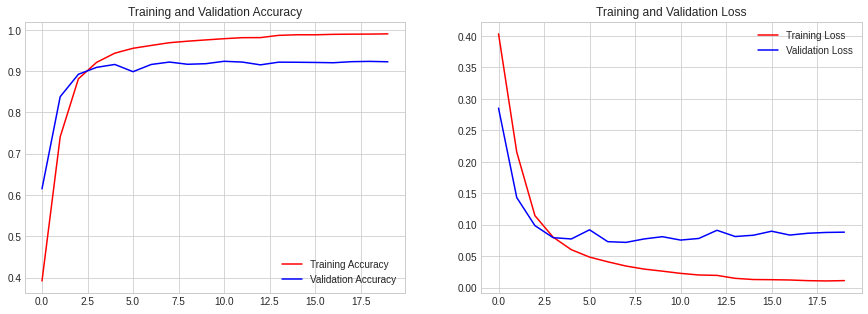

In [30]:
plot_history(history_emot)

In [31]:
model_emot.save_weights('model_emot_weights.h5')
model_emot.save('model_emot.h5')

In [32]:
def predict_emotion(sentence, model = model_emot):
  sequence = tokenizer.texts_to_sequences([sentence])
  test = pad_sequences(sequence)
  predict_array = model.predict(test)[0]

  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  prod = ['Anger', 'Fear', 'Happy', 'Love', 'Sadness', 'Surprise']
  df['Emotion'] = prod
  df = df[['Emotion', 'Probability']]

  predict_label = np.argmax(model.predict(test), axis=1)[0]

  if predict_label == 0:
      predict_product = 'Anger'
  elif predict_label == 1:
      predict_product = 'Fear'
  elif predict_label == 2:
      predict_product = 'Happy'
  elif predict_label == 3:
      predict_product = 'Love'
  elif predict_label == 4:
      predict_product = 'Sadness'
  else:
      predict_product = 'Surprise'

  return predict_product, df

##Percobaan

In [33]:
sentence = "Iam so happy today"

label, df = predict_emotion(sentence)

print('"' + sentence + '"')
print("\nThe sentence is detected as " + label)
print()
print(df.sort_values(by='Probability', ascending=False))
print()

"Iam so happy today"

The sentence is detected as Happy

    Emotion  Probability
2     Happy     0.995045
4   Sadness     0.003902
1      Fear     0.000842
3      Love     0.000097
5  Surprise     0.000071
0     Anger     0.000044



Dan akhirnya didapatkan hasil prediksi yang tepat, maka model yang telah dibuat telah berhasil mendeteksi kalimat yang diinputkan
